In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

def filter_peaks(peak_positions, threshold=60):
    """
    Filters peaks to remove those that are within a given nm range of a stronger peak.
    """
    peak_positions = peak_positions.sort_values(by='nm')
    filtered_peaks = []
    
    for i, row in peak_positions.iterrows():
        if not filtered_peaks or (row['nm'] - filtered_peaks[-1]['nm']) > threshold:
            filtered_peaks.append(row)
        else:
            # Keep the higher intensity peak
            if row['percentage'] > filtered_peaks[-1]['percentage']:
                filtered_peaks[-1] = row
    
    return pd.DataFrame(filtered_peaks)

def plot_spectra(file_details, x_min, x_max, title="Spectrum Visualization", save_path=None):
    """
    Plots multiple spectra on a single graph with specified x-axis limits.

    Parameters:
        file_details (list of tuples): List of (file_path, color) tuples for spectra.
        x_min (float): Minimum wavelength value for the x-axis.
        x_max (float): Maximum wavelength value for the x-axis.
        title (str): Title of the plot.
        save_path (str, optional): File path to save the image in high resolution.
    """
    plt.figure(figsize=(16, 6))

    for file_path, color in file_details:
        try:
            data = pd.read_csv(file_path, sep=r'\s+', header=None, names=['nm', 'percentage'], engine='python')
            data = data.dropna()
            data['nm'] = pd.to_numeric(data['nm'], errors='coerce')
            data['percentage'] = pd.to_numeric(data['percentage'], errors='coerce')
            data = data.dropna()

            # Filter data within x_min and x_max
            data = data[(data['nm'] >= x_min) & (data['nm'] <= x_max)]

            # Find peaks above 10% intensity
            peaks, properties = find_peaks(data['percentage'], height=60)
            peak_positions = data.iloc[peaks]

            # Filter peaks to remove close ones within 25 nm
            filtered_peaks = filter_peaks(peak_positions, threshold=25)

            peak_wavelengths_intensities = ", ".join(f"{row['nm']:.1f} nm ({row['percentage']:.1f}%)"
                                                     for _, row in filtered_peaks.iterrows())
            legend_label = f"{file_path} (Peaks: {peak_wavelengths_intensities})" if peak_wavelengths_intensities else file_path

            # Plot spectrum
            plt.plot(data['nm'], data['percentage'], label=legend_label, color=color)

            # Highlight peaks
            plt.scatter(filtered_peaks['nm'], filtered_peaks['percentage'], color=color, marker='o', zorder=5)

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    plt.title(title, fontsize=16)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Intensity (%)", fontsize=14)
    
    # Set x-axis limits
    plt.xlim(x_min, x_max)
    
    # Adjust x-axis grid to show ticks every 25 nm within specified limits
    x_ticks = np.arange(int(x_min // 25) * 25, int(x_max // 25) * 25 + 25, 25)
    plt.xticks(x_ticks)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='-')

    plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

    plt.tight_layout(pad=2.0)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {save_path}")

    plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_spectra_subtract_fixed(blank_file, sample_files, labels, blank_color, sample_colors, title, save_path, x_min, x_max, y_min, y_max):
    blank_data = pd.read_csv(blank_file, sep=r'\s+', header=0, names=['nm', 'percentage'], engine='python')
    blank_data = blank_data.apply(pd.to_numeric, errors='coerce').dropna()

    plt.figure(figsize=(12, 6))

    for i, sample_file in enumerate(sample_files):
        try:
            sample_data = pd.read_csv(sample_file, sep=r'\s+', header=0, names=['nm', 'percentage'], engine='python')
            sample_data = sample_data.apply(pd.to_numeric, errors='coerce').dropna()

            merged_data = pd.merge(sample_data, blank_data, on='nm', how='inner', suffixes=('_sample', '_blank'))

            # Subtract blank intensity
            merged_data['percentage_corrected'] = merged_data['percentage_sample'] - merged_data['percentage_blank']

            filtered_data = merged_data[(merged_data['nm'] >= x_min) & (merged_data['nm'] <= x_max)]

            color = sample_colors[i % len(sample_colors)]
            plt.plot(filtered_data['nm'], filtered_data['percentage_corrected'], label=labels[i], color=color)
        except Exception as e:
            print(f"Error processing {sample_file}: {e}")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity (%)")
    plt.title(title)
    plt.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    x_ticks = np.arange(int(x_min // 25) * 25, int(x_max // 25) * 25 + 25, 25)
    plt.xticks(x_ticks)
    
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.axhline(0, color=blank_color, linewidth=0.8, linestyle='-')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {save_path}")

    plt.show()

## 2 - Sample (Control)

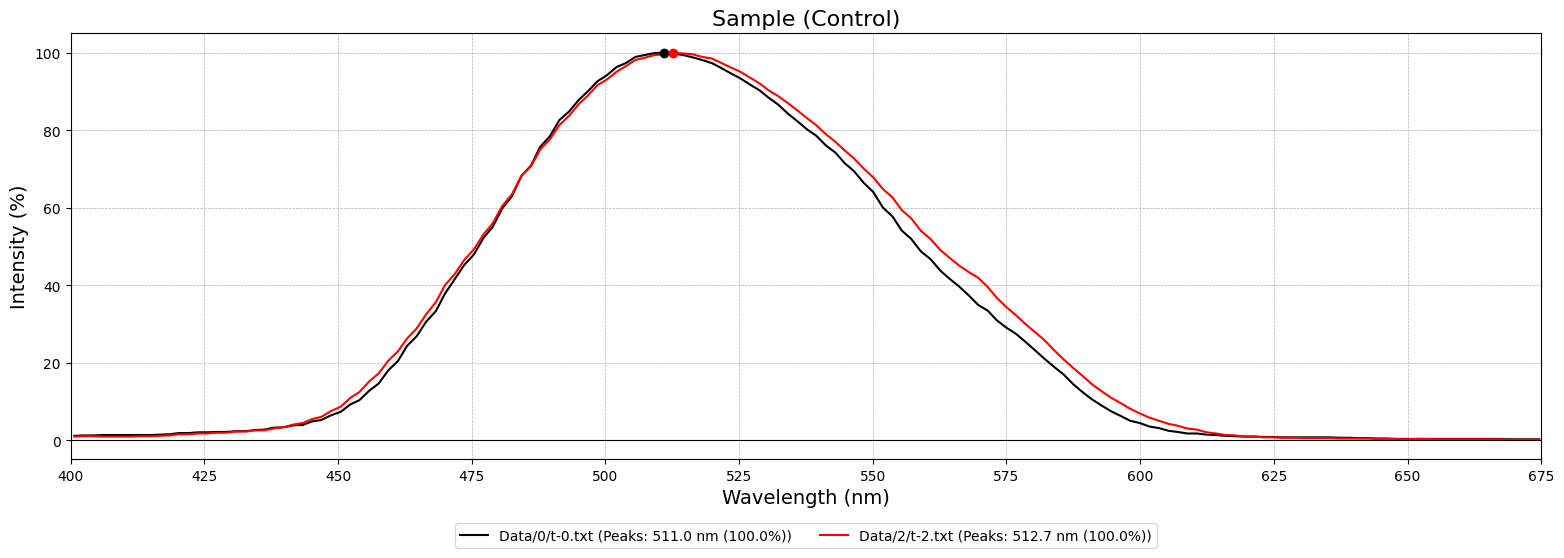

In [3]:
file_details = [
    ('Data/0/t-0.txt', "black"),
    ('Data/2/t-2.txt', "red"),
]

x_min = 400
x_max = 675

plot_spectra(file_details,x_min, x_max, title="Sample (Control)", save_path="")

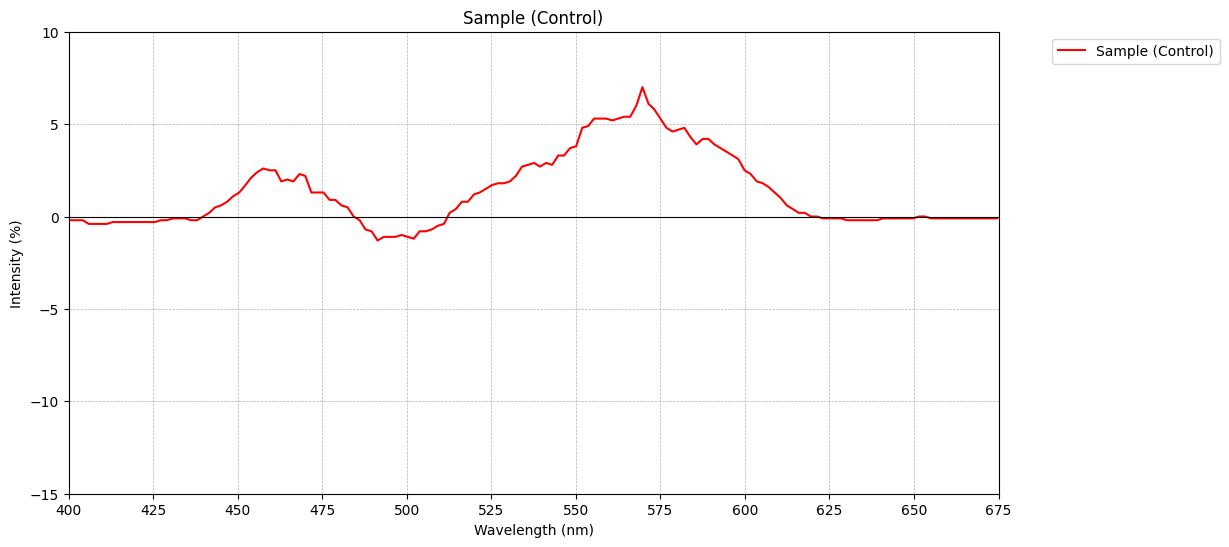

In [4]:
blank_file = 'Data/0/t-0.txt'

sample_files = ['Data/2/t-2.txt']

labels = ["Sample (Control)"]

sample_colors = ["red"]

x_min = 400
x_max = 675
y_min = -15
y_max = 10

plot_spectra_subtract_fixed(blank_file, sample_files, labels, "black", sample_colors, 
                                     "Sample (Control)", "", 
                                     x_min, x_max, y_min, y_max)

## 4 - Sample (C2CA)

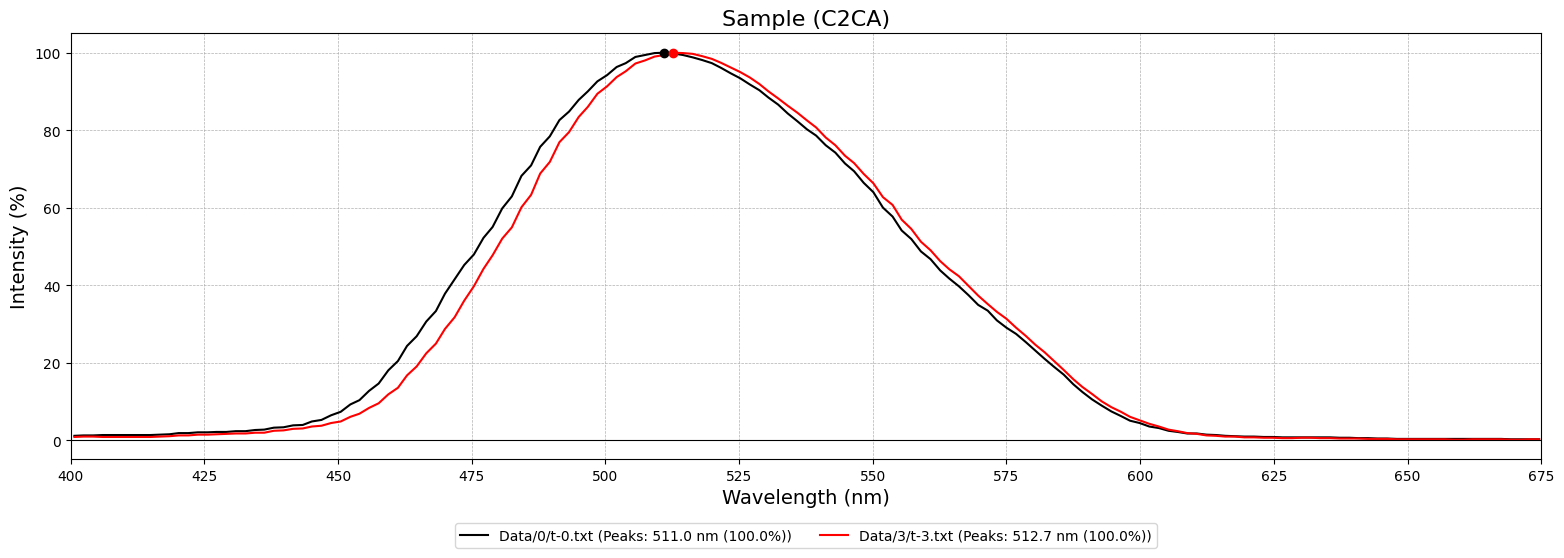

In [5]:
file_details = [
    ('Data/0/t-0.txt', "black"),
    ('Data/3/t-3.txt', "red"),
]

x_min = 400
x_max = 675

plot_spectra(file_details,x_min, x_max, title="Sample (C2CA)", save_path="")

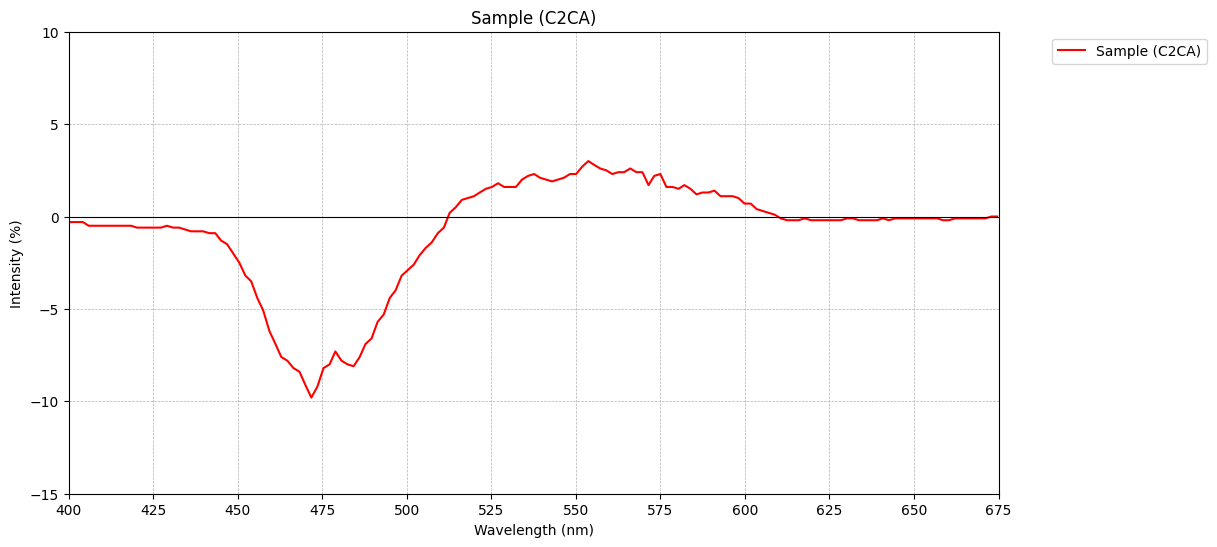

In [6]:
blank_file = 'Data/0/t-0.txt'

sample_files = ['Data/3/t-3.txt']

labels = ["Sample (C2CA)"]

sample_colors = ["red"]

x_min = 400
x_max = 675
y_min = -15
y_max = 10

plot_spectra_subtract_fixed(blank_file, sample_files, labels, "black", sample_colors, 
                                     "Sample (C2CA)", "", 
                                     x_min, x_max, y_min, y_max)

## 7 - Sample (RCA)

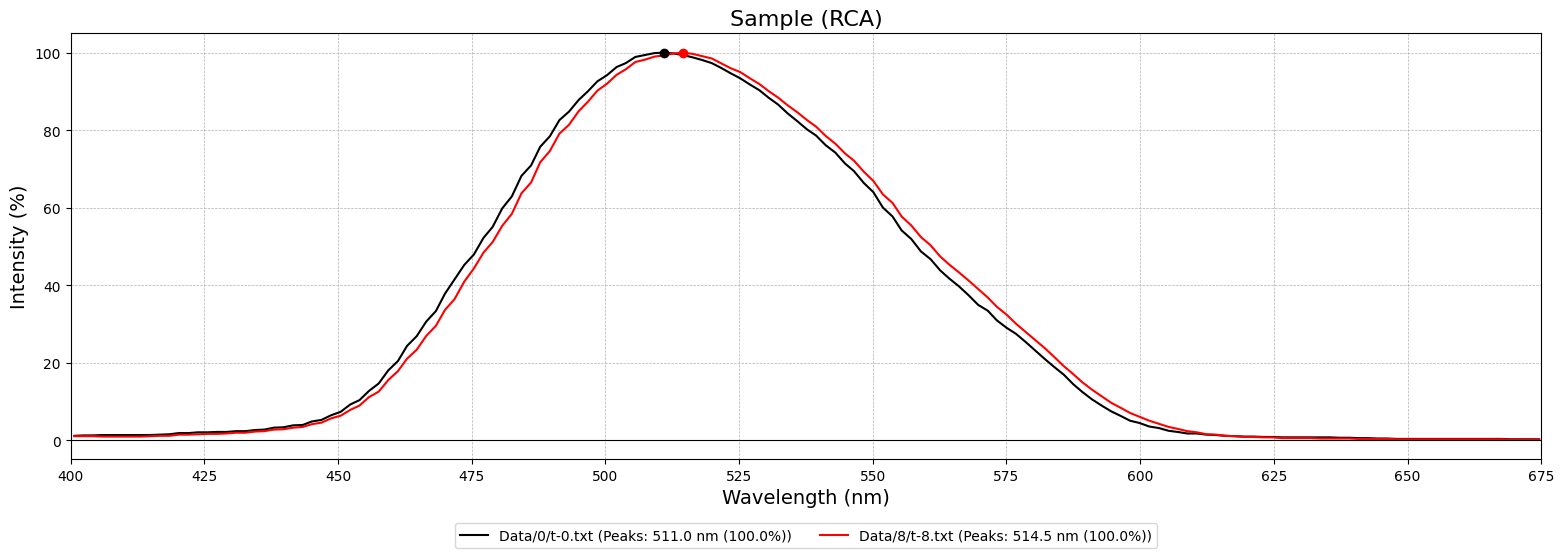

In [7]:
file_details = [
    ('Data/0/t-0.txt', "black"),
    ('Data/8/t-8.txt', "red"),
]

x_min = 400
x_max = 675

plot_spectra(file_details,x_min, x_max, title="Sample (RCA)", save_path="")

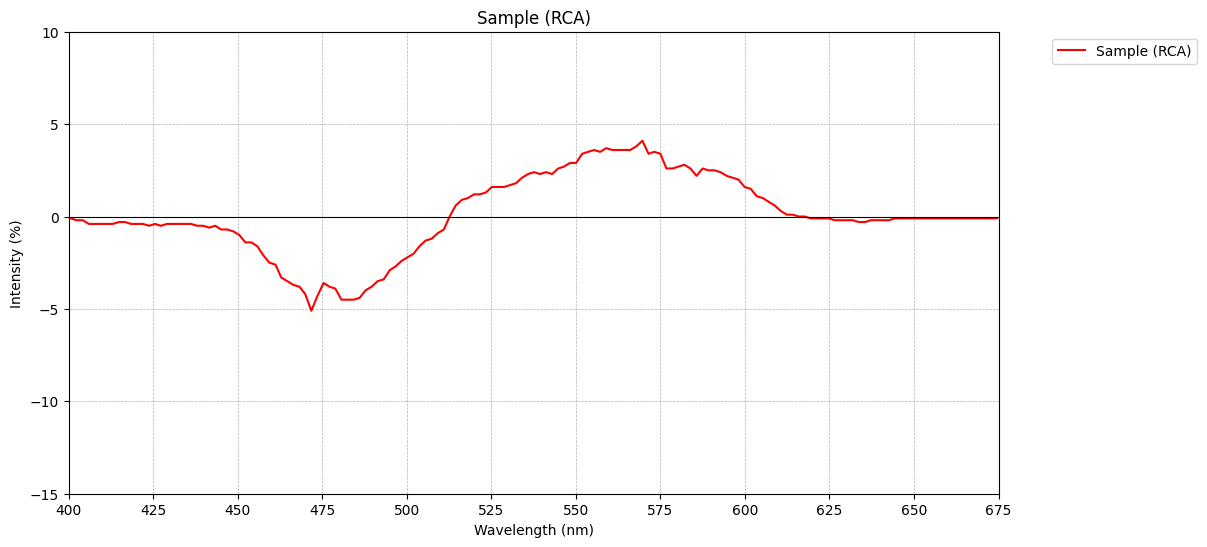

In [8]:
blank_file = 'Data/0/t-0.txt'

sample_files = ['Data/8/t-8.txt']

labels = ["Sample (RCA)"]

sample_colors = ["red"]

x_min = 400
x_max = 675
y_min = -15
y_max = 10

plot_spectra_subtract_fixed(blank_file, sample_files, labels, "black", sample_colors, 
                                     "Sample (RCA)", "", 
                                     x_min, x_max, y_min, y_max)

## COMBINED

Plot saved as ../Images/green1.png


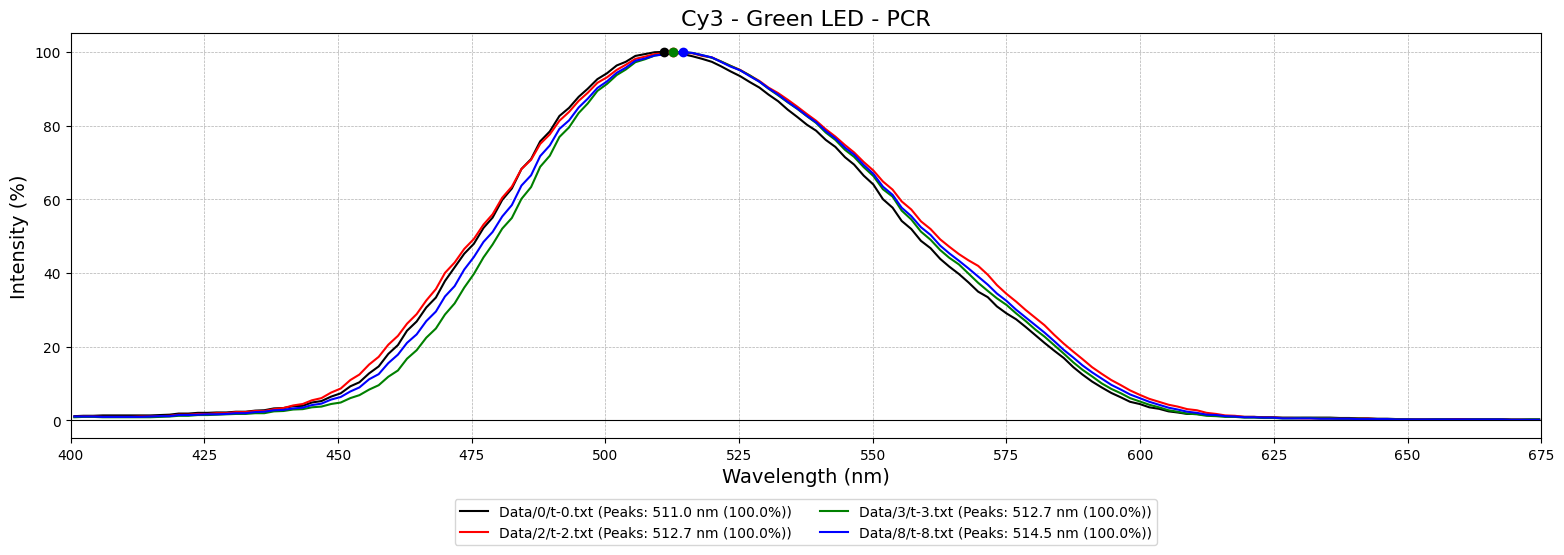

In [9]:
file_details = [
    ('Data/0/t-0.txt', "black"),
    ('Data/2/t-2.txt', "red"),
    ('Data/3/t-3.txt', "green"),
    ('Data/8/t-8.txt', "blue"),
]

x_min = 400
x_max = 675

plot_spectra(file_details,x_min, x_max, title="Cy3 - Green LED - PCR", save_path="../Images/green1.png")

Plot saved as ../Images/green1-sub.png


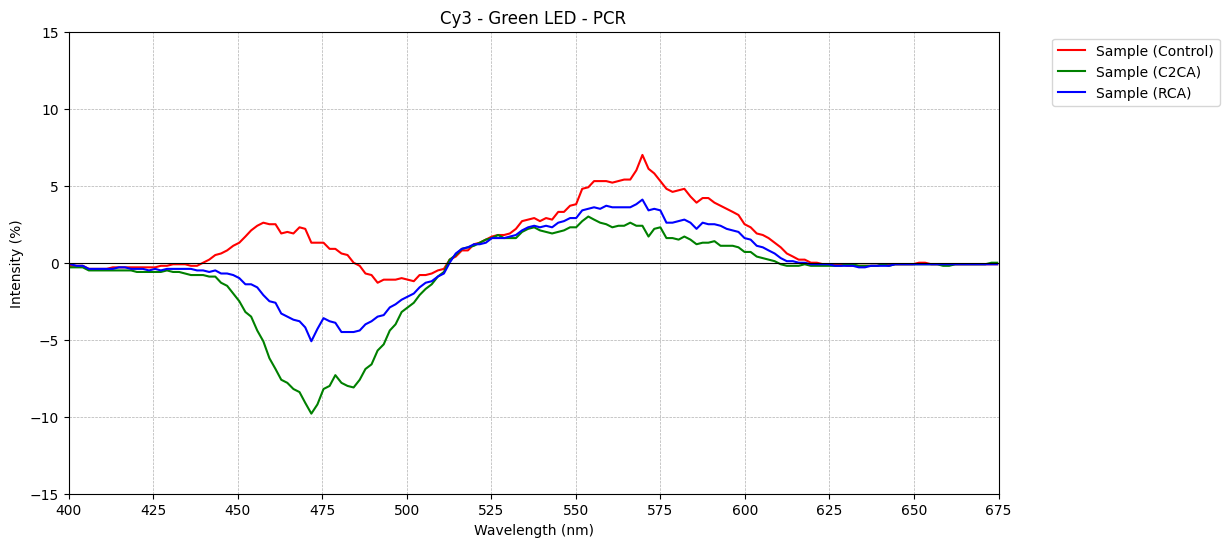

In [10]:
blank_file = 'Data/0/t-0.txt'

sample_files = ['Data/2/t-2.txt','Data/3/t-3.txt','Data/8/t-8.txt']

labels = ["Sample (Control)","Sample (C2CA)", "Sample (RCA)"]

sample_colors = ["red","green", "blue"]

x_min = 400
x_max = 675
y_min = -15
y_max = 15

plot_spectra_subtract_fixed(blank_file, sample_files, labels, "black", sample_colors, 
                                     "Cy3 - Green LED - PCR", "../Images/green1-sub.png", 
                                     x_min, x_max, y_min, y_max)